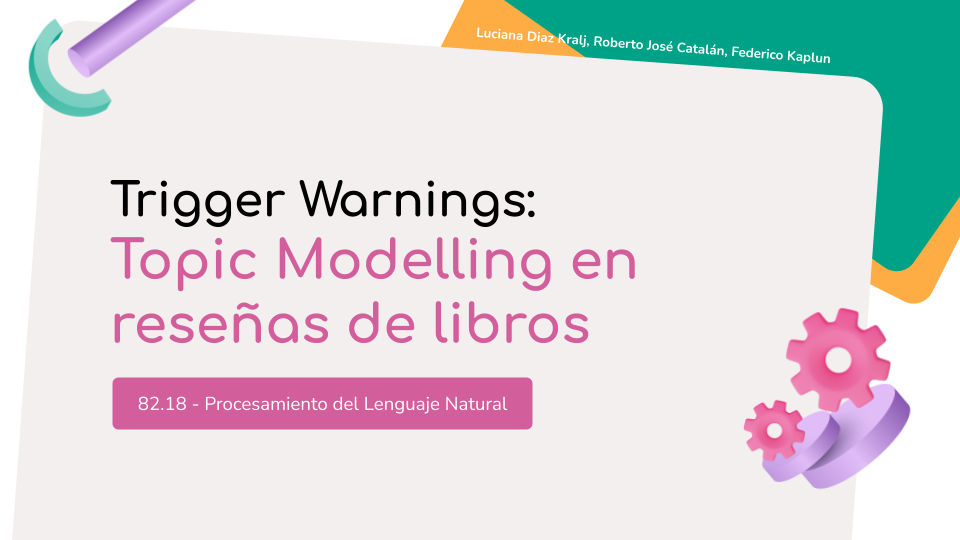

# Trigger Warnings: Topic Modelling en reseñas de libros
Notebook para la presentación final de **"Trigger Warnings: Topic Modelling en reseñas de libros"** 📚

**Integrantes:**
* Luciana Diaz Kralj
* Roberto José Catalán
* Federico Kaplun

**Recursos**

*Link a la presentación: https://docs.google.com/presentation/d/1opUrrjHtRX1eXWjVKaNgyLC-hTPuK4KfQ0ANpvtrqWQ/edit?usp=sharing*

*Dataset utilizado: https://www.kaggle.com/competitions/goodreads-books-reviews-290312/*

*Notebook original: https://towardsdatascience.com/hands-on-topic-modeling-with-python-1e3466d406d7*

In [1]:
# !pip install pyLDAvis
# !python3 -m spacy download en_core_web_sm

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("fivethirtyeight")
pd.set_option('display.max_colwidth', 80)
import matplotlib.patheffects as path_effects
import nltk
import numpy as np
import gensim
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Data
En esta sección obtenemos el contenido de los datasets a utilizar, y los guardamos en dataframes.

**Importante:** Seguir estos pasos para utilizar Kaggle desde Google Colab https://www.kaggle.com/general/74235

In [3]:
import json
from google.colab import drive

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/kaggle.json", 'r') as f:
    api_token= json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Mounted at /content/drive


In [4]:
!kaggle competitions download -c goodreads-books-reviews-290312

goodreads-books-reviews-290312.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
import os

for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

In [6]:
os.listdir()

['.config',
 'goodreads_sample_submission.csv',
 'goodreads-books-reviews-290312.zip',
 'goodreads_train.csv',
 'goodreads_test.csv',
 'drive',
 'sample_data']

In [7]:
train_df = pd.read_csv('/content/goodreads_train.csv', usecols=['review_id', 'book_id', 'rating', 'review_text'])
test_df = pd.read_csv('/content/goodreads_test.csv', usecols=['review_id', 'book_id', 'review_text'])

In [8]:
train_df.head(2)

,book_id,review_id,rating,review_text
0,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,"This is a special book. It started slow for about the first third, then in t..."
1,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in December: http://www.audible.com/...


In [9]:
test_df.head(2)

,book_id,review_id,review_text
0,7092507,5c4df7e70e9b438c761f07a4620ccb7c,"** spoiler alert ** \n This is definitely one of my favorites among the ""foo..."
1,5576654,8eaeaf13213eeb16ad879a2a2591bbe5,"** spoiler alert ** \n ""You are what you drink."" \n I'm a huge fan of coffee..."


Para tener más adelante un dataset más grande:

In [10]:
reviews = pd.concat([train_df, test_df], ignore_index=True)
reviews.head(5)

,book_id,review_id,rating,review_text
0,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5.0,"This is a special book. It started slow for about the first third, then in t..."
1,16981,a5d2c3628987712d0e05c4f90798eb67,3.0,Recommended by Don Katz. Avail for free in December: http://www.audible.com/...
2,28684704,2ede853b14dc4583f96cf5d120af636f,3.0,"A fun, fast paced science fiction thriller. I read it in 2 nights and couldn..."
3,27161156,ced5675e55cd9d38a524743f5c40996e,0.0,"Recommended reading to understand what is going on in middle america, and po..."
4,25884323,332732725863131279a8e345b63ac33e,4.0,"I really enjoyed this book, and there is a lot to recommend it. It did drag ..."


## 2.  Data Cleaning and Preprocessing
En este paso tomamos los textos de las reseñas y quitamos los caracteres, palabras y expresiones que no son relevantes, para tener mejores resultados en el modelado.

In [11]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
stop_words.extend(['spoiler', 'book', 'novel', 'read', 'like', 'make', 'really', 'much', 'would', 'also', 'go', 'could', 'one', 'character', 'get', 'way', 'think', 'give', 'see', 'say', 'story', 'first', 'even', 'know', 'tap', 'review', 'lot', 'hannah', 'clay', 'want', 'everyone', 'let', 'come', 'still', 'series', 'shake', 'ti', 'zach', 'star', 'change', 'rate', 'feel', 'ever', 'never', 'well'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

Tomamos solo los datos de un libro que nos interese, para enfocar el análisis:

In [12]:
book_id = 29844228

In [13]:
reviews_for_book = reviews[reviews['book_id'] == book_id]
reviews_for_book.head(5)

,book_id,review_id,rating,review_text
5251,29844228,a561565bbfa956a523f5a1e423b1e122,5.0,I raced through this one. I decided to read it after hearing Jay Asher discu...
15193,29844228,a93e49de4b0e7e47e76f32cf036f9a29,3.0,I wanted to read this book because it has become rather controversial lately...
18259,29844228,9b5f47ee4547d01f0d25192afdf98f44,2.0,"i HATE both of the main characters but some bits were ok. \n 2*s for me is ""..."
28162,29844228,a169f0bdd21c53670a0d547de4232500,5.0,I liked it a lot. I thought the way the story unfolded was different than an...
37594,29844228,b4fcb87be02d6ce8d933d91a7fb13795,5.0,Wow! That was a heartbreaking but great read. I definitely recommend this to...


Añadimos funciones para el preprocesamiento de las reseñas:

In [14]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

# Convert to list
data = reviews_for_book.review_text.values.tolist()
data_words = list(sent_to_words(data)) # print(data_words[:1])

Incluimos manejo de bigramas y trigramas:

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

# Processed Text Data
data_ready = process_words(data_words)

Hacemos una pequeña preview de las palabras más comunes en las reseñas:

In [16]:
string_book_reviews = list(map(lambda list_words: ' '.join(list_words), data_ready))
join_book_reviews = ' '.join(string_book_reviews)
join_book_reviews

'race decide hear last month fast reason short lead smoothly stop suicide theme turn mystery reveal side tape time keep wonder person tape person fit end trouble real live people choose suicide sometimes similar reason realistic trouble understand course trouble understand mess part person life mess entire life understand influence people live small action pay understand affect dismiss poor react end actually learn lesson teach become controversial lately turn netflix popularity course skyrocket people worry glorifie suicide suicide directly blame show prominently show obvious reason direct connection deal depression life suicidal past cause uproar short version simply late scapegoat people blame tragedy interesting format follow timeline concurrently tape talk decision end life blame multitude people thing time listen tape walk different location lightly interact people timeline apart reaction wish love detail reason different depression affect people different mention female male gue

In [17]:
def plot_wordcount(reviews):
  counter = Counter(reviews.split())
  most_frequent = counter.most_common(40)

  fig = plt.figure(1, figsize = (30,10))
  _ = pd.DataFrame(most_frequent, columns=("words","count"))
  sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
  plt.xticks(rotation=45)

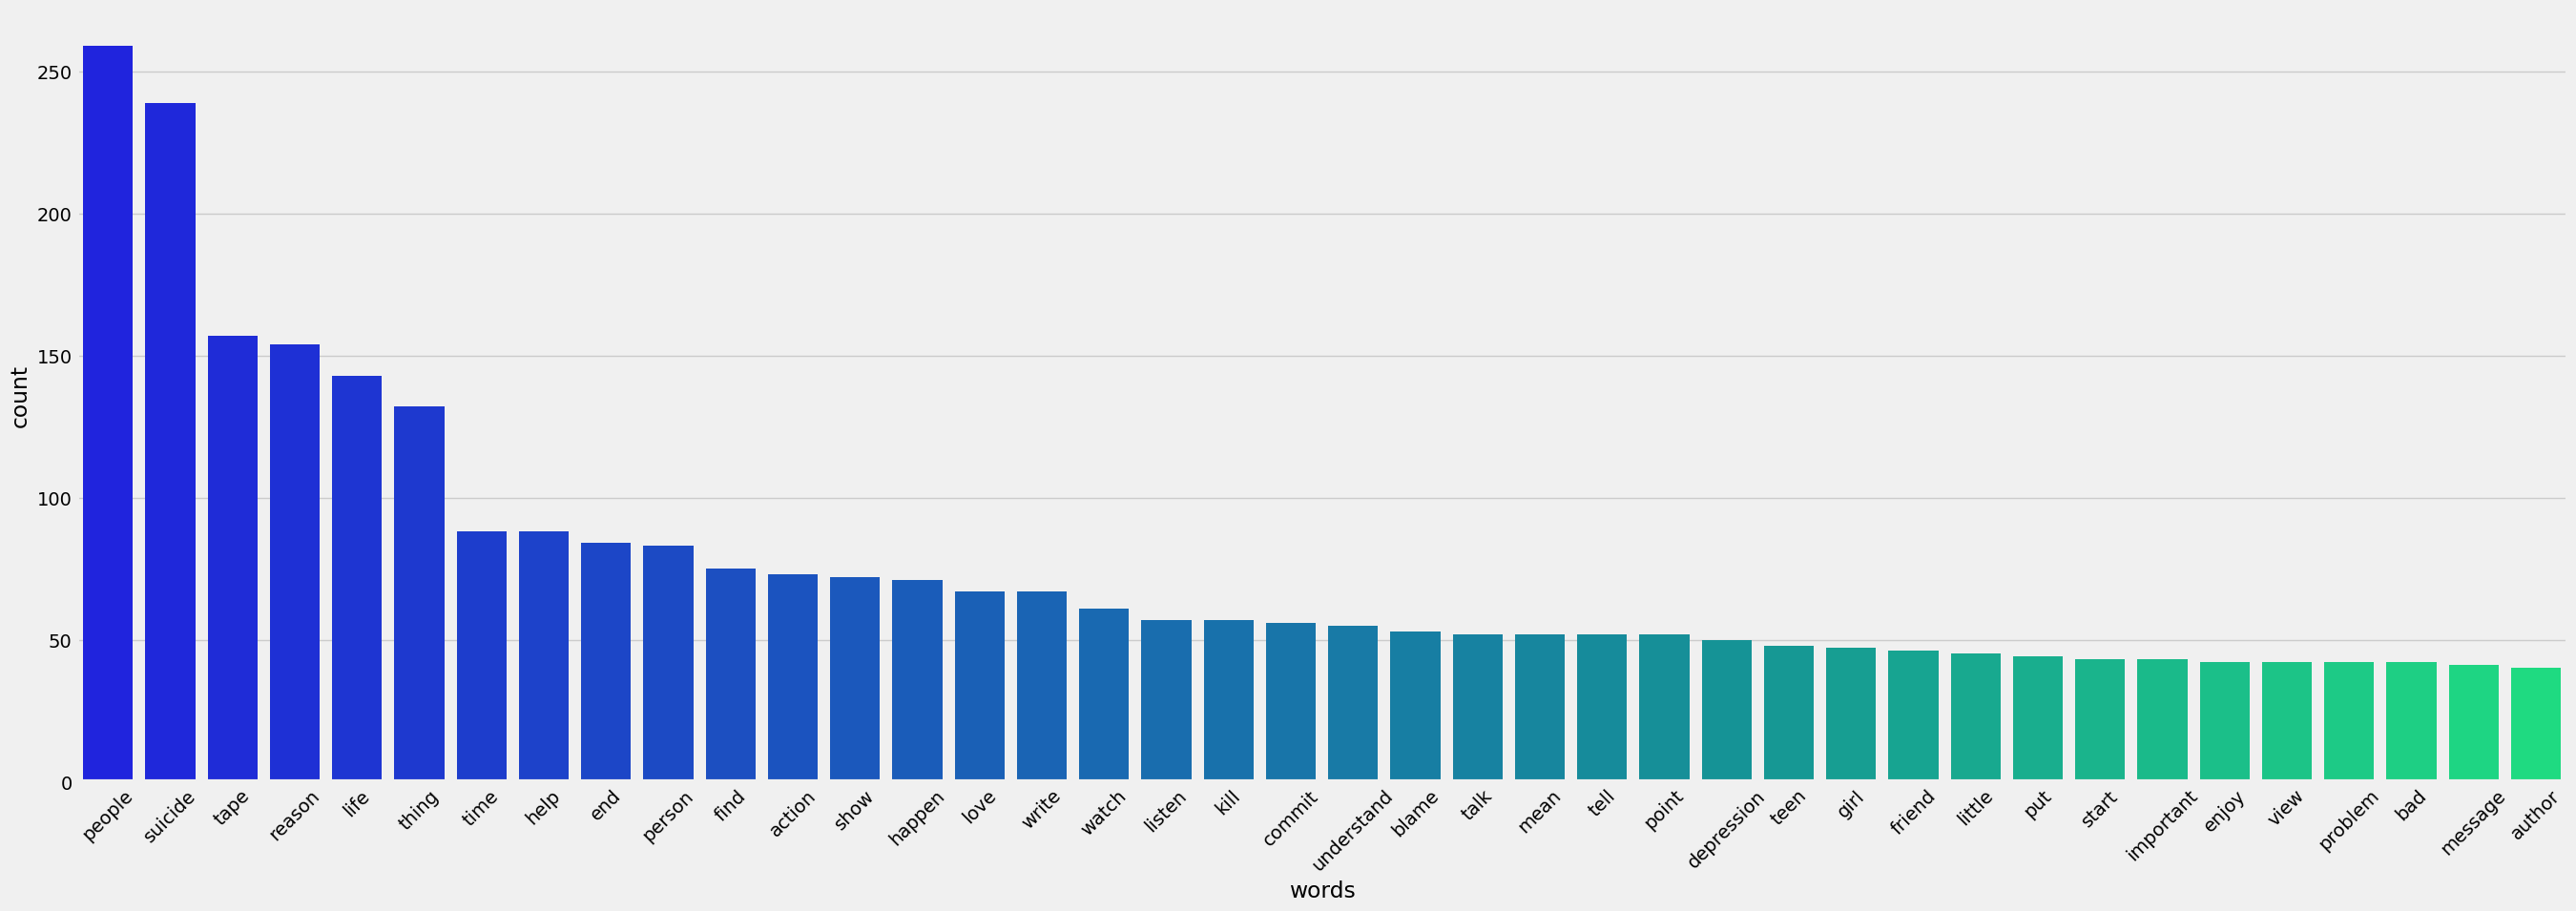

In [18]:
plot_wordcount(join_book_reviews)

Armamos entonces nuestro corpus:

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

##3. Clusters

Definimos el numero de tópicos comparando con distintos valores:

In [23]:
from gensim.models import CoherenceModel
def get_coherence(coherence_type, n_topics:list):
    number_of_topics = []
    coherence_score = []
    for i in n_topics:
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                              id2word=id2word,
                                              num_topics=i,
                                              random_state=11,
                                              passes=10,
                                              alpha='auto',
                                              iterations=100,
                                              per_word_topics=True)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence=coherence_type)
        coherence_lda = coherence_model_lda.get_coherence()
        number_of_topics.append(i)
        coherence_score.append(coherence_lda)
    return number_of_topics, coherence_score

In [24]:
n_topics=[2, 4, 8, 10, 12]

Como vimos en clase, las mejores son UCI Coherence Score y UMass Coherence Score:

[Text(0.5, 1.0, 'UCI Coherence Score')]

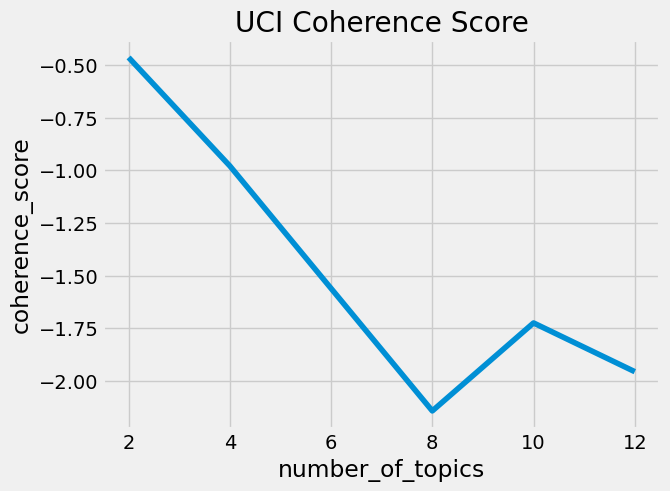

In [25]:
number_of_topics, coherence_score = get_coherence('c_uci', n_topics)
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics, 'coherence_score':coherence_score})
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score').set(title="UCI Coherence Score")

[Text(0.5, 1.0, 'UMass Coherence Score')]

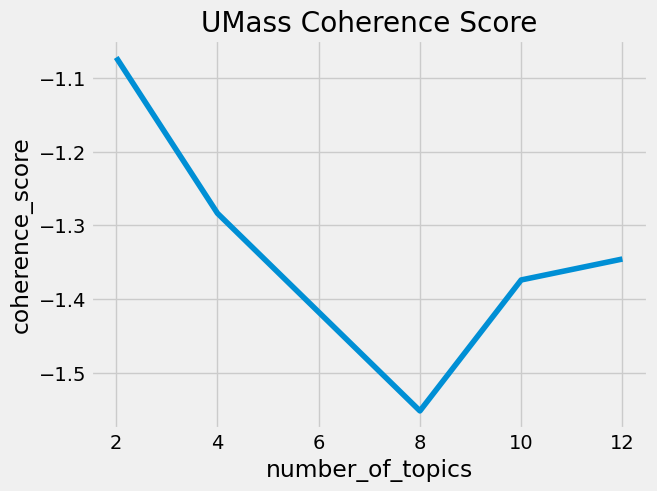

In [26]:
number_of_topics, coherence_score = get_coherence('u_mass', n_topics)
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics, 'coherence_score':coherence_score})
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score').set(title="UMass Coherence Score")

Ambos coinciden en que 8 es un buen número de clústers:

In [27]:
num_topics = 8

Creamos el corpus con la data procesada en el paso anterior y aplicamos LDA:

In [28]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.023*"sad" + 0.022*"hard" + 0.016*"handle" + 0.014*"topic" + 0.014*"care" '
  '+ 0.014*"however" + 0.013*"actually" + 0.013*"bother" + 0.013*"love" + '
  '0.012*"term"'),
 (1,
  '0.028*"parent" + 0.022*"honestly" + 0.021*"teen" + 0.018*"friend" + '
  '0.018*"experience" + 0.015*"send" + 0.014*"focus" + 0.013*"bad" + '
  '0.013*"include" + 0.013*"believe"'),
 (2,
  '0.036*"people" + 0.030*"mean" + 0.030*"suicide" + 0.026*"blame" + '
  '0.020*"problem" + 0.019*"depression" + 0.016*"reason" + 0.015*"work" + '
  '0.014*"deserve" + 0.014*"relate"'),
 (3,
  '0.035*"suicide" + 0.032*"people" + 0.029*"end" + 0.027*"thing" + '
  '0.025*"life" + 0.021*"help" + 0.020*"write" + 0.019*"action" + 0.015*"time" '
  '+ 0.014*"point"'),
 (4,
  '0.052*"tape" + 0.017*"person" + 0.017*"real" + 0.015*"death" + '
  '0.014*"choose" + 0.013*"rape" + 0.012*"baker" + 0.012*"wrong" + '
  '0.012*"decide" + 0.011*"kill"'),
 (5,
  '0.023*"happen" + 0.021*"watch" + 0.020*"little" + 0.018*"reason" + '
  '0.01

Damos formato a la salida cargándolo en un dataframe:

In [29]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame(columns=['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                new_row = pd.DataFrame({'Dominant_Topic': [int(topic_num)], 'Topic_Perc_Contrib': [round(prop_topic,4)], 'Keywords': [topic_keywords]})
                sent_topics_df = pd.concat([sent_topics_df, new_row], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.4534,"tape, person, real, death, choose, rape, baker, wrong, decide, kill","[race, decide, hear, last, month, fast, reason, short, lead, smoothly, stop,..."
1,1,2,0.8247,"people, mean, suicide, blame, problem, depression, reason, work, deserve, re...","[become, controversial, lately, turn, netflix, popularity, course, skyrocket..."
2,2,5,0.9028,"happen, watch, little, reason, start, leave, find, enjoy, view, kind","[hate, main, bit, enjoy, simply, shame, start, promise]"
3,3,2,0.7792,"people, mean, suicide, blame, problem, depression, reason, work, deserve, re...","[unfold, different, write]"
4,4,3,0.8250,"suicide, people, end, thing, life, help, write, action, time, point","[heartbreake, great, definitely, recommend]"


## 4. Analisis

Cargamos en el dataframe el texto mas representativo para cada tópico:

In [30]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Topic_Perc_Contrib'], ascending=False).head(1)], axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.8648,"sad, hard, handle, topic, care, however, actually, bother, love, term","[phenomenal, love, wonderful, sad, frustrating, time, write, justice, hour, straight, mean, actu..."
1,1,0.5160,"parent, honestly, teen, friend, experience, send, focus, bad, include, believe","[crucify, infuriate, disturb, explain, couple, friend, experience, awful, find, remotely, surpri..."
2,2,0.8247,"people, mean, suicide, blame, problem, depression, reason, work, deserve, relate","[become, controversial, lately, turn, netflix, popularity, course, skyrocket, people, worry, glo..."
3,3,0.9905,"suicide, people, end, thing, life, help, write, action, time, point","[end, matter, message, powerful, yet, tragic, tell, beautiful, heart, wrench, tell, unique, wond..."
4,4,0.5708,"tape, person, real, death, choose, rape, baker, wrong, decide, kill","[vapid, manipulative, self, righteous, idiot, send, reader, awful, message, killing, teach, bull..."
5,5,0.9906,"happen, watch, little, reason, start, leave, find, enjoy, view, kind","[list, long, time, release, finally, force, find, time, disappoint, thirteen_reason, grab, atten..."
6,6,0.6465,"selfish, part, hand, people, ask, understand, hold, lesson, responsibility, suppose","[hear, time, year, pick, interested, staying, power, warrant, help, delete, end, though, glimpse..."
7,7,0.7812,"hurt, especially, bad, else, close, weak, high_school, suffer, realize, push","[clever, original, ill]"


Graficamos la distribución de cantidad de palabras por documento (review):

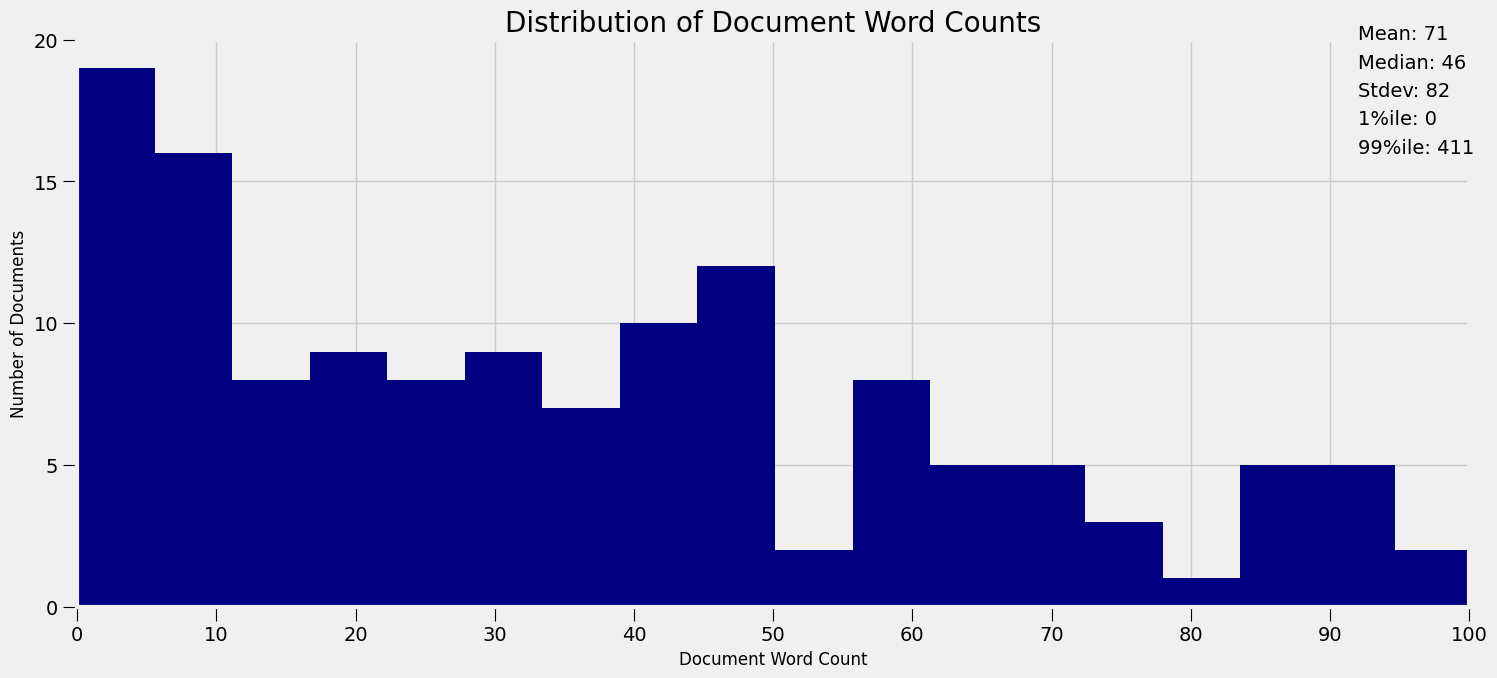

In [31]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7))
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(92, 20, "Mean: " + str(round(np.mean(doc_lens))))
plt.text(92, 19, "Median: " + str(round(np.median(doc_lens))))
plt.text(92, 18, "Stdev: " + str(round(np.std(doc_lens))))
plt.text(92, 17, "1%ile: " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(92, 16, "99%ile: " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100))
plt.xlabel('Document Word Count', fontsize=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.xticks(np.arange(0, 101, step=10))
plt.yticks(np.arange(0, 21, step=5))
plt.tick_params(size=10)
plt.title('Distribution of Document Word Counts', fontdict=dict(size=20))
plt.show()

Ploteamos el wordcloud del top 10 de palabras para cada tópico:

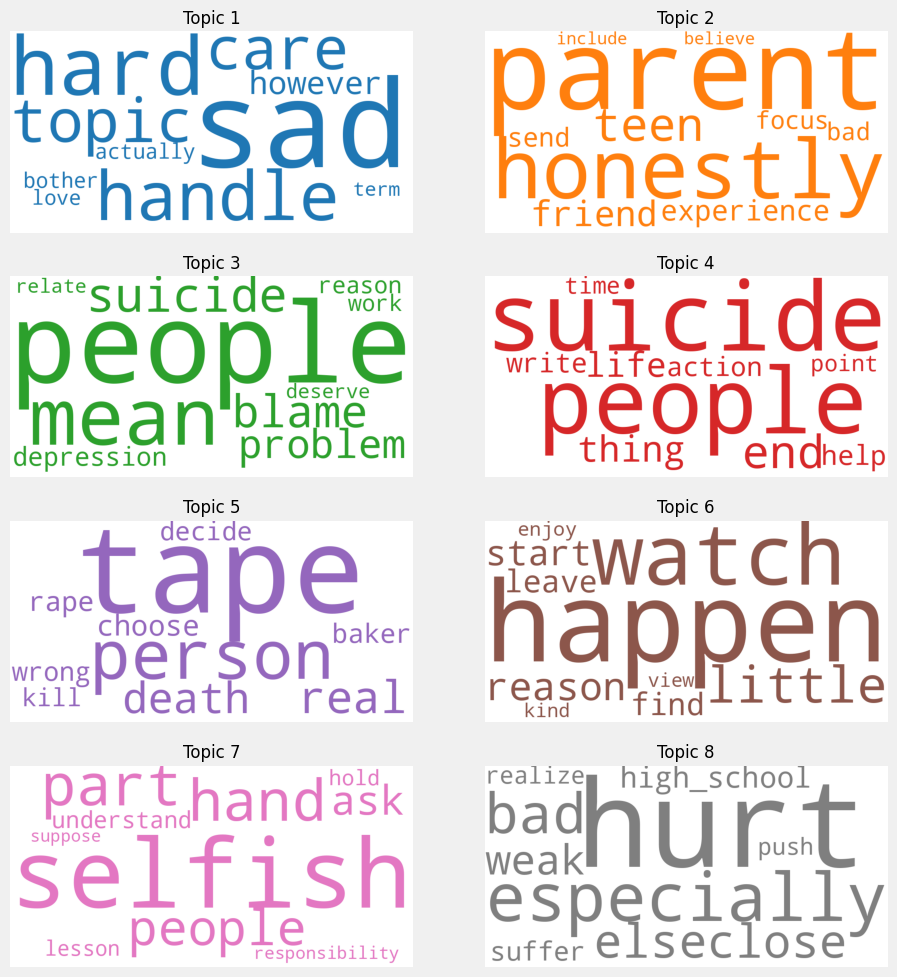

In [32]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0,
                  width=1000,
                  height=500)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=12))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Graficamos la cantidad de apariciones e importancia de cada keyboard de los tópicos:

<ipython-input-33-a655f2d41a6f>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


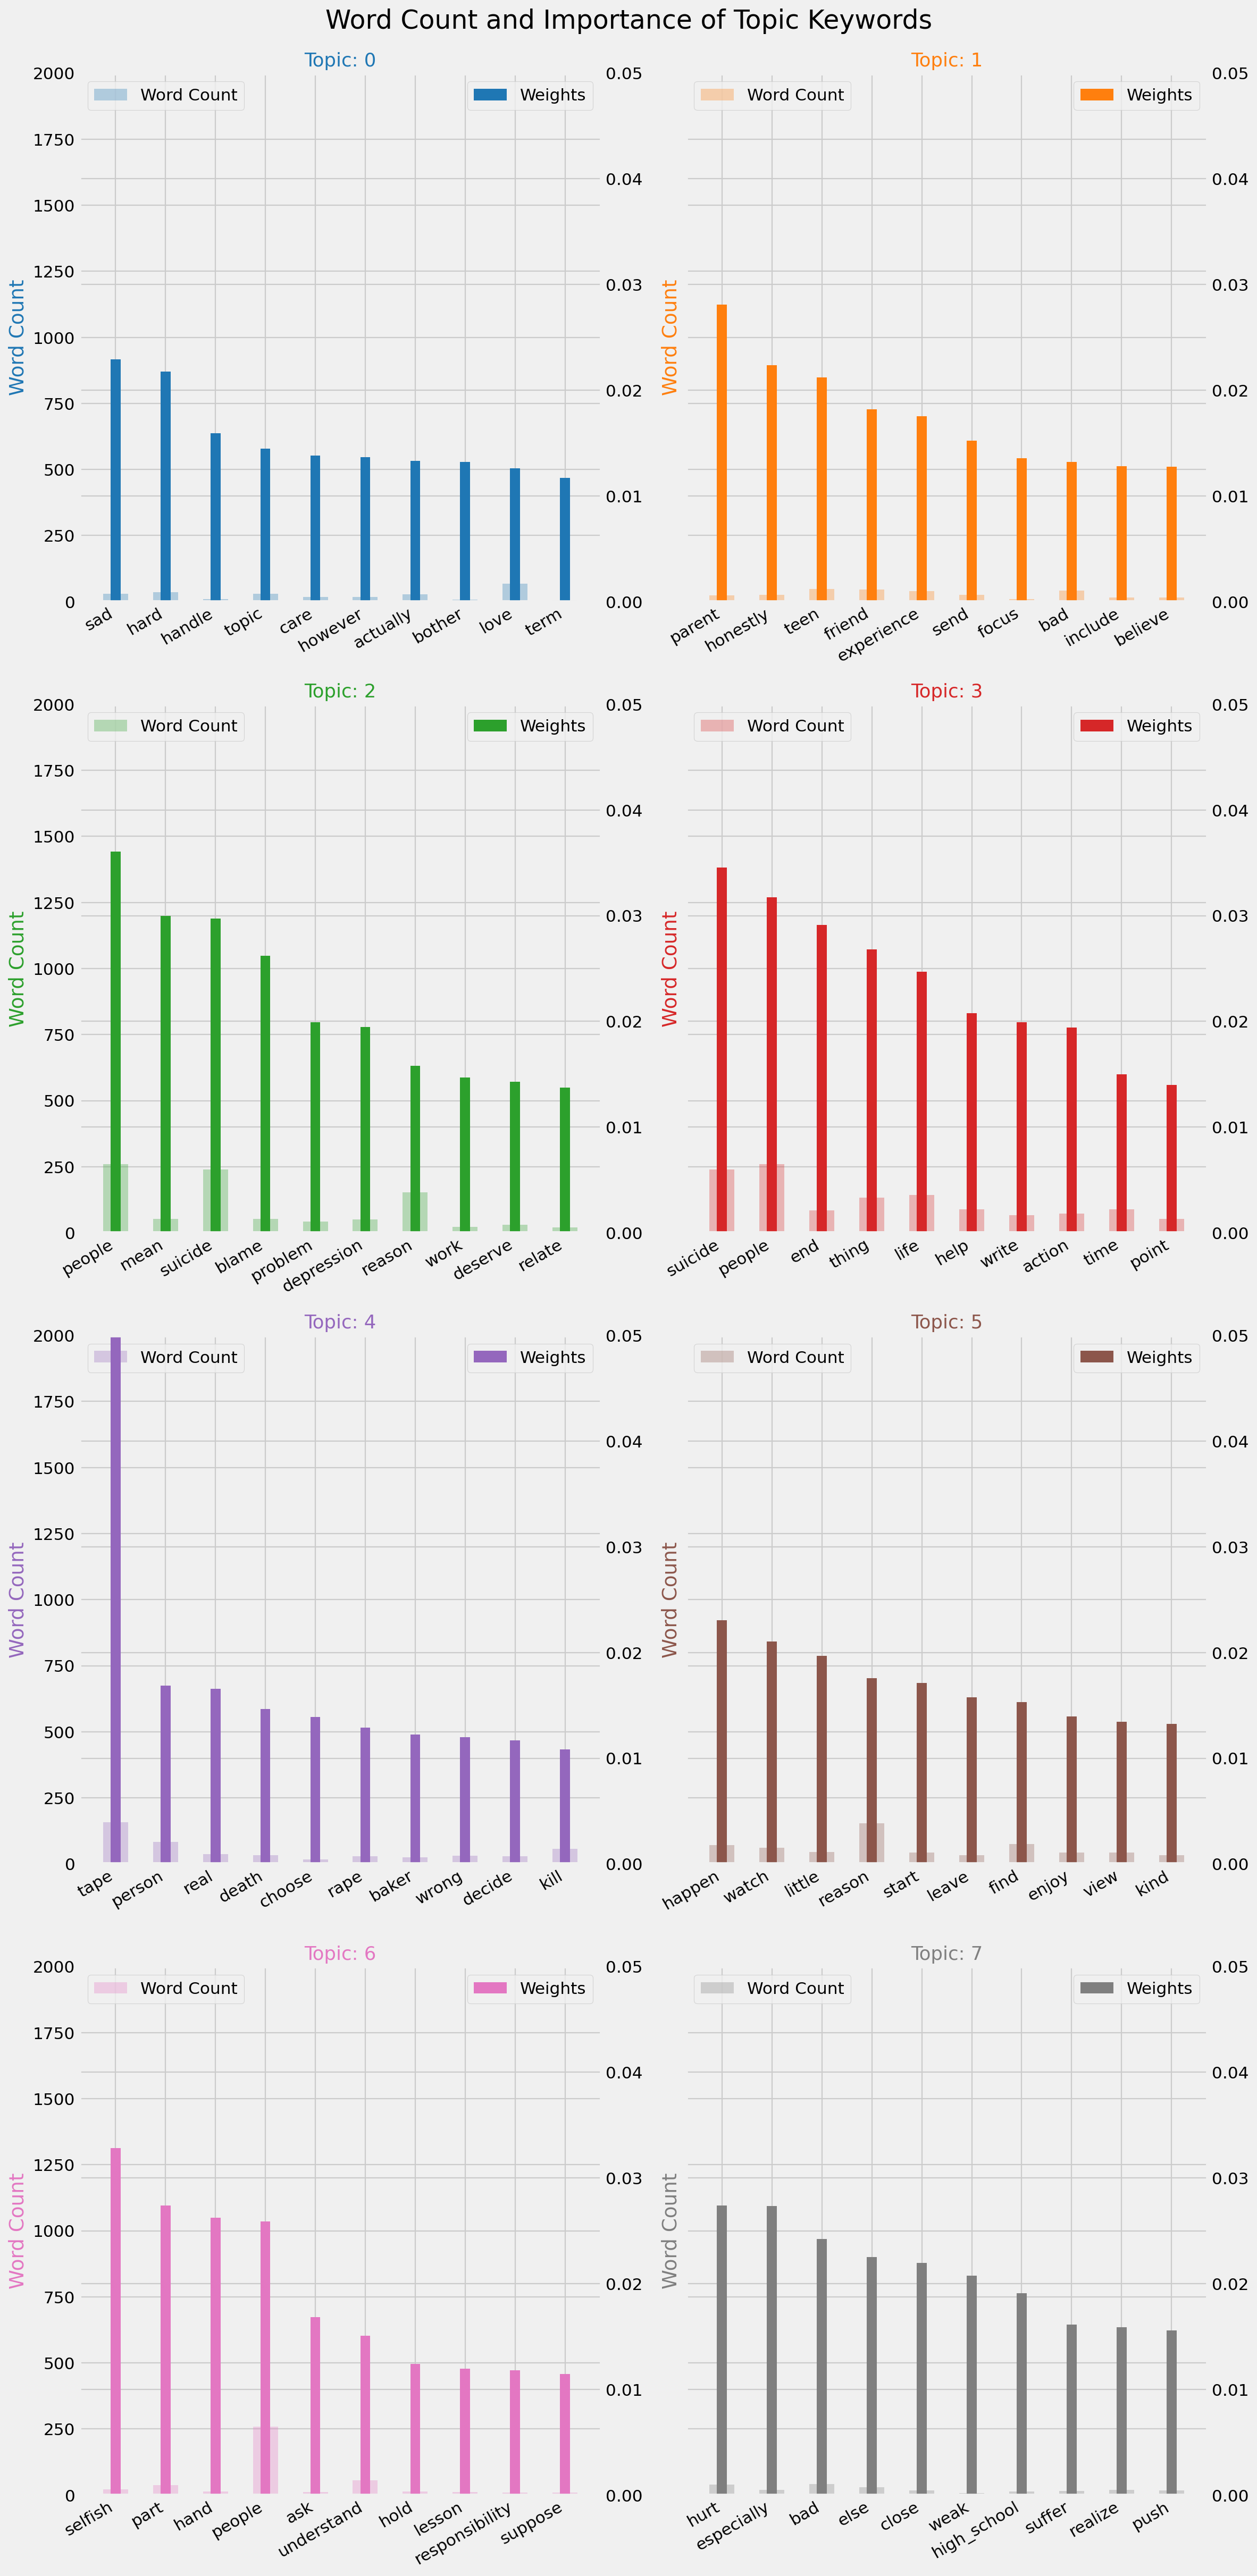

In [33]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(15,30), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.05); ax.set_ylim(0, 2000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=1)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.01)
plt.show()

Vemos la representación en pyLDAvis:

In [34]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.261257  0.175380       1        1  27.411997
5      0.129037 -0.294491       2        1  19.428463
4      0.018430 -0.024436       3        1  13.542233
2      0.097054  0.067590       4        1  12.062805
1     -0.209925  0.057758       5        1   9.687400
6     -0.066315 -0.009347       6        1   6.409255
7     -0.133542 -0.005889       7        1   5.818128
0     -0.095995  0.033436       8        1   5.639719, topic_info=          Term        Freq       Total Category  logprob  loglift
42        tape  118.000000  118.000000  Default  30.0000  30.0000
25      people  201.000000  201.000000  Default  29.0000  29.0000
41     suicide  179.000000  179.000000  Default  28.0000  28.0000
7          end  104.000000  104.000000  Default  27.0000  27.0000
95        mean   52.000000   52.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1469   respect    3.921539    6.849706   Topic8  -5.1970   2.3176
95        mean    6.084160   52.143527   Topic8  -4.7578   0.7270
142      write    5.834882   81.401279   Topic8  -4.7996   0.2398
45        time    5.591636   81.091010   Topic8  -4.8422   0.2010
441   consider    4.266897   12.102677   Topic8  -5.1126   1.8328

[351 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
176       1  0.980368    able
863       3  0.951933  accept
912       4  0.905817     act
0         1  0.968993  action
0         6  0.028925  action
...     ...       ...     ...
142       4  0.073709   write
142       8  0.073709   write
938       2  0.488942   wrong
938       3  0.488942   wrong
415       5  0.933403   young

[369 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 5, 3, 2, 7, 8, 1])